In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import * 
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

import pandas as pd
import numpy as np
import os

fastai.version.__version__

'1.0.39'

In [3]:
# make sure CUDA is available and enabled
print('CUDA enabled:',torch.cuda.is_available()) 
print('CUDNN enabled:', torch.backends.cudnn.enabled)

CUDA enabled: True
CUDNN enabled: True


In [4]:
def recreate_directory(directory):
    !rm -R {directory} 2>nul
    !mkdir {directory}

# Dataset preprocessing

In [5]:
current_dir = os.getcwd()
input_path =f'{current_dir}/data'
train_dir = f"{input_path}/train"
train_labels = f"{input_path}/train.csv"
test_dir = f"{input_path}/test"
model_dir = f'{current_dir}/models'

## Train model

In [6]:
SZ = 224
BS = 64
NUM_WORKERS = 0
SEED=0
arch = models.resnet50

### TEST -------

In [7]:
df = pd.read_csv(train_labels)
df = df[df['Id']!='new_whale']
df = df.sample(frac=0.05).reset_index()

print(df.shape)
print(df.head())

(785, 3)
   index          Image         Id
0  19236  c1d59f8da.jpg  w_242fb46
1  16885  a9a25ac23.jpg  w_f8b4ea9
2   1504  0efdffd67.jpg  w_6ae4956
3  18898  be52b468f.jpg  w_fd3e556
4    266  02a7e1f6c.jpg  w_c8d5ad5


In [8]:
grouped_df = df.groupby('Id')
grouped_counted = grouped_df.count().sort_values(by=['Image'], ascending=False)
grouped_counted = grouped_counted[(grouped_counted['Image']>5) & (grouped_counted['Image']<1000)]
print(len(grouped_counted))
print(grouped_counted.sum().Image, 'of', len(df))
print(grouped_counted.head())

1
8 of 785
           index  Image
Id                     
w_9c506f6      8      8


In [9]:
valid_pct = 0.2

valid_filenames = pd.DataFrame(columns=df.columns)

for name, group in enumerate(grouped_df):
    sub_df = group[1]
#     if group[0] != 'new_whale' and (len(sub_df)>5):
    sample = sub_df.sample(frac=valid_pct)
    valid_filenames = valid_filenames.append(sample, ignore_index=True)

In [10]:
valid_filenames.drop(labels=['index'], axis=1, inplace=True, errors='ignore')

print(valid_filenames.shape)
print(valid_filenames.head())

(26, 2)
           Image         Id
0  8bfe10108.jpg  w_03670aa
1  fc5d04058.jpg  w_0369a5c
2  0cc97c518.jpg  w_08630fd
3  3216ee4c5.jpg  w_0bc078c
4  ebdd6652b.jpg  w_17b0d3a


In [11]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [12]:
valid_files = ItemList.from_df(df=valid_filenames, path=train_dir, cols=['Image'])

In [13]:
test_files = ImageItemList.from_folder(test_dir)

In [14]:
%%time
# TODO label from df?
data = (
    ImageItemList
        .from_df(df, train_dir, cols=['Image'])
        .split_by_files(valid_files)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(test_files)
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=input_path)
        .normalize(imagenet_stats)
)

CPU times: user 14.2 s, sys: 152 ms, total: 14.3 s
Wall time: 6.13 s


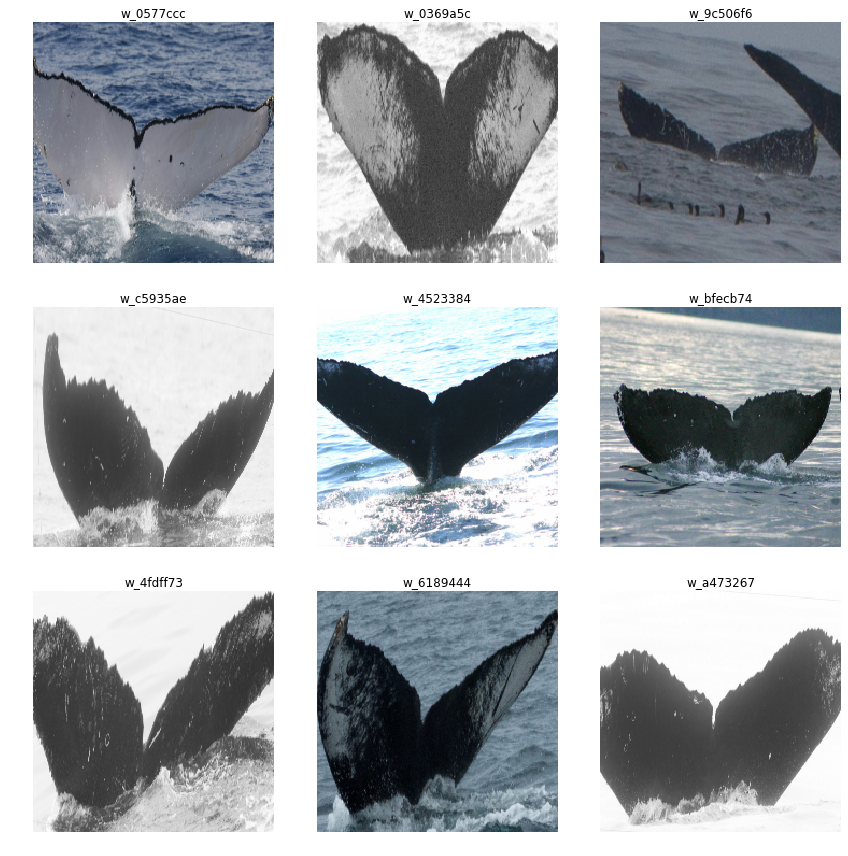

In [15]:
data.show_batch(rows=3, fig_size=(SZ, SZ))

# Learning rate

In [17]:
learn = create_cnn(data, arch, metrics=accuracy, model_dir=model_dir)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


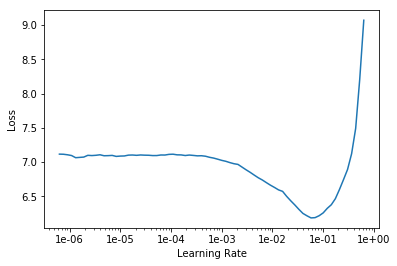

In [19]:
learn.recorder.plot()

# Precompute

In [ ]:
# learn = create_cnn(data, arch, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
# learn few epochs with unfreeze
learn.unfreeze()

In [ ]:
lr_rate = 1e-3
learn.fit_one_cycle(20, [lr_rate/100, lr_rate/10, lr_rate])

# Prediction & Summition - TODO

In [ ]:
# classes = learn.data.classes + ["new_whale"]
# print(len(classes))

In [ ]:
# log_preds,y = learn.TTA()

In [ ]:
# preds = torch.cat((log_preds, torch.ones_like(log_preds[:, :1])), 1)

In [ ]:
# preds.shape

In [ ]:
# submittion_df = pd.DataFrame(columns=["Image", "Id"])

In [ ]:
# for idx, val in enumerate(os.listdir(test_dir)):
#     class_ids = preds[idx].argsort()[-5:]
#     class_1 = classes[class_ids[0]]
#     class_2 = classes[class_ids[1]]
#     class_3 = classes[class_ids[2]]
#     class_4 = classes[class_ids[3]]
#     class_5 = classes[class_ids[4]]
#     prediction_row = f'{class_1} {class_2} {class_3} {class_4} {class_5}'
#     submittion_df = submittion_df.append({'Image' : val.split(".")[0], 'Id': prediction_row}, ignore_index=True)

In [ ]:
# print(submittion_df.shape)
# submittion_df.head()

In [ ]:
# submittion_df.to_csv('submission2.csv', index=False)

In [ ]:
# print(submission.head())
# print(submission.shape)